In [10]:
import numpy as np
import random
import sklearn
import pandas as pd
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

#Make plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Autoreload external python modules
%load_ext autoreload
%autoreload 2

train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,ImageId,EncodedPixels
6646,358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a...,"[27728, 7, 27982, 10, 28237, 12, 28493, 13, 28..."
3930,1ec74a26e772966df764e063f1391109a60d803cff9d15...,"[17608, 8, 17863, 11, 18119, 12, 18375, 12, 18..."
5883,2e2d29fc44444a85049b162eb359a523dec108ccd5bd75...,"[69795, 2, 69799, 4, 70050, 10, 70306, 10, 705..."


In [24]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_test = lambda in_path: in_path.split('\\')[0]
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
29043,.\input\stage1_train\f487cc82271cf84b4414552aa...,f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8...,masks,train,stage1
17633,.\input\stage1_train\94519eb45cbe1573252623b7e...,94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b6...,masks,train,stage1


In [25]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 3s


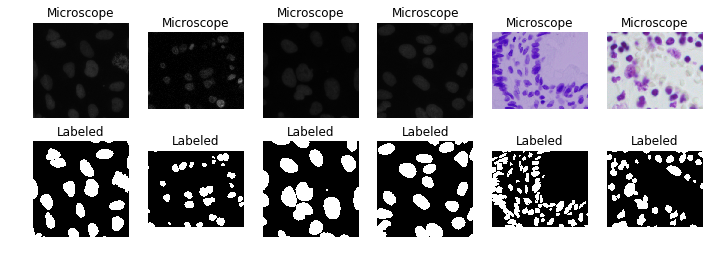

In [26]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [62]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))

print(train_img_df['Red'].shape)
training_table_x = pd.concat([train_img_df['Red'],train_img_df['Green'],train_img_df['Blue'],train_img_df['Gray']],axis=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

training_y = train_img_df['masks']
print(training_y[40].shape)
#training_y = training_y.astype('int')
knn.fit(training_table_x, training_y)

(670,)
(256, 320)


ValueError: Unknown label type: 'unknown'

In [31]:
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process


,ImageId,Stage,images
32,550450e4bff4036fd671decdc5d42fec23578198d6a2fd...,stage1,"[[[0.117647058824, 0.117647058824, 0.117647058..."
